In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import os
import random
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2025-10-15 05:32:26.588655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760506346.777070      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760506346.829795      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMG_SIZE = (32, 32)
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 50

In [4]:
train_df = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Train.csv")
test_df = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Test.csv")

train_imgs = "/kaggle/input/gtsrb-german-traffic-sign/Train"
test_imgs = "/kaggle/input/gtsrb-german-traffic-sign/Test"

In [5]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [6]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

train_df["ClassName"] = train_df['ClassId'].map(class_names)
test_df["ClassName"] = test_df['ClassId'].map(class_names)

In [8]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,ClassName
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,Single curve right
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,Single curve right
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,Single curve right
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,Single curve right
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,Single curve right


In [9]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,ClassName
0,53,54,6,5,48,49,16,Test/00000.png,Trucks and tractors over 3.5 tons prohibited
1,42,45,5,5,36,40,1,Test/00001.png,Speed Limit (30Km/hr)
2,48,52,6,6,43,47,38,Test/00002.png,Keep right
3,27,29,5,5,22,24,33,Test/00003.png,Mandatory direction of travel right
4,60,57,5,5,55,52,11,Test/00004.png,Right of way


In [10]:
train_df['ClassName'].value_counts()

ClassName
Speed Limit (50Km/hr)                           2250
Speed Limit (30Km/hr)                           2220
Yeild right of way                              2160
Priotity Road                                   2100
Keep right                                      2070
No Passing for trucks over 3.5 tons             2010
Speed Limit (70Km/hr)                           1980
Speed Limit (80Km/hr)                           1860
Construction side ahead                         1500
No Passing                                      1470
Speed Limit (100Km/hr)                          1440
Speed Limit (60Km/hr)                           1410
Speed Limit (120Km/hr)                          1410
Right of way                                    1320
Mandatory direction of travel ahead             1200
Danger                                          1200
Entery prohibited                               1110
Stop                                             780
Wild animal crossing                

In [11]:
test_df['ClassName'].value_counts()

ClassName
Speed Limit (50Km/hr)                           750
Yeild right of way                              720
Speed Limit (30Km/hr)                           720
Keep right                                      690
Priotity Road                                   690
Speed Limit (70Km/hr)                           660
No Passing for trucks over 3.5 tons             660
Speed Limit (80Km/hr)                           630
Construction side ahead                         480
No Passing                                      480
Speed Limit (100Km/hr)                          450
Speed Limit (60Km/hr)                           450
Speed Limit (120Km/hr)                          450
Right of way                                    420
Mandatory direction of travel ahead             390
Danger                                          390
Entery prohibited                               360
Wild animal crossing                            270
Stop                                            270
Ma

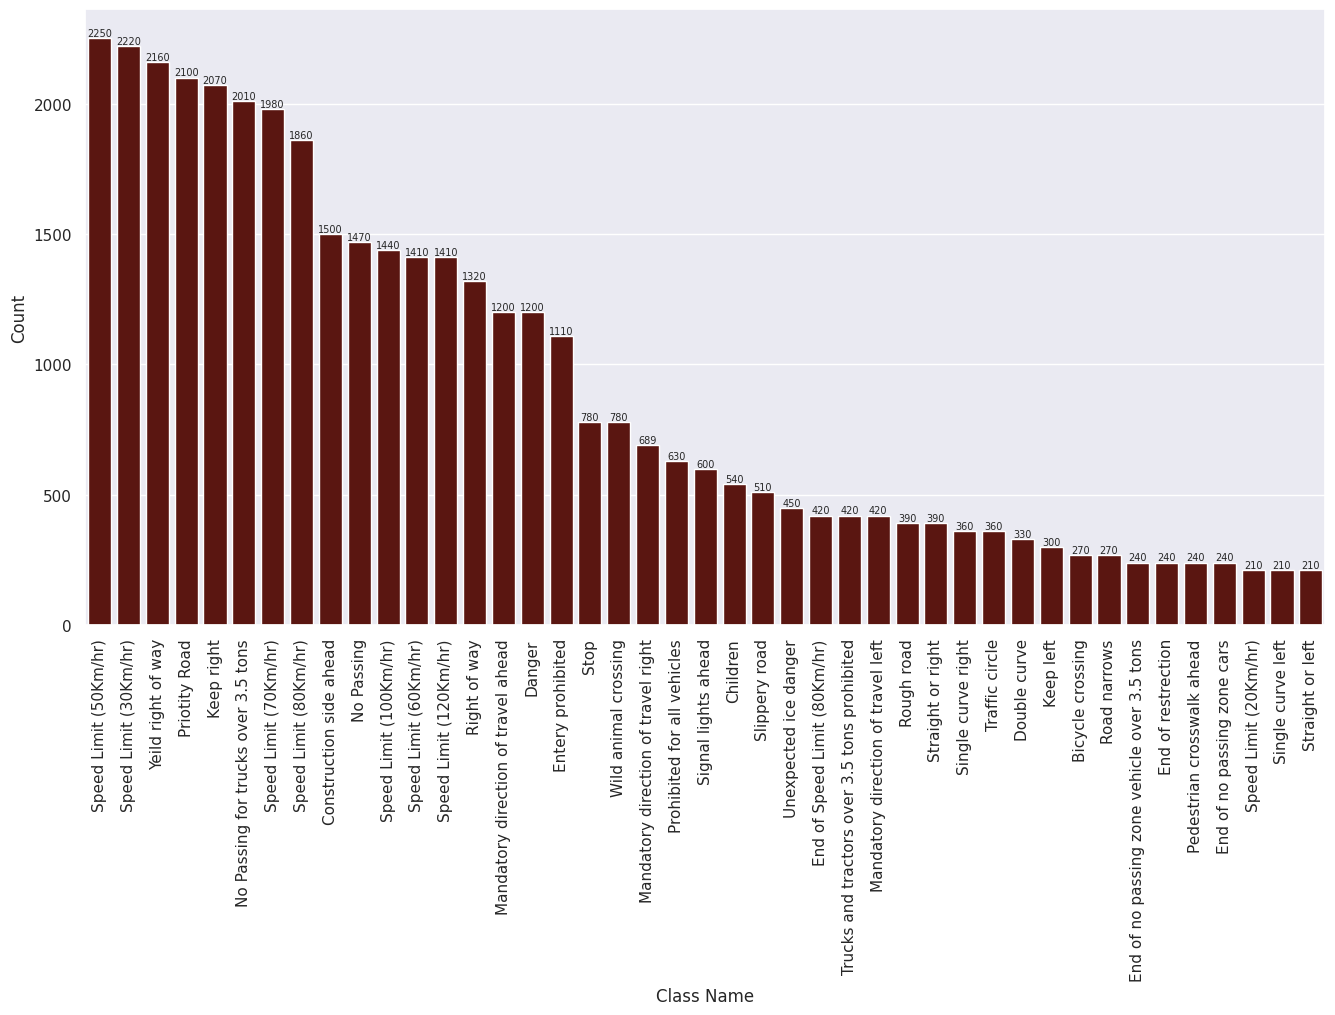

In [12]:
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=train_df, x="ClassName", order=train_df["ClassName"].value_counts().index, color="#660B05")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fontsize=7)
plt.show()

# **Data Spliting and Preprocessing**


![Stratified Sampling](https://www.scribbr.com/wp-content/uploads/2020/09/stratified-sample-7-2048x863.png)

### you can find more about stratified sampling here
https://www.scribbr.com/methodology/stratified-sampling/

In [13]:
train_df["ClassId_str"] = train_df["ClassId"].astype(str)
train_df["ClassId"] = train_df["ClassId"].astype(int)
train_df["Path"] = train_df["Path"].str.replace("Train/", "")

train_data, valid_data = train_test_split(train_df, test_size=0.2, stratify=train_df['ClassId'], random_state=42)

In [14]:
num_classes=len(train_df["ClassName"].unique())
num_classes

43

In [15]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, stratify=train_df['ClassId'], random_state=42)

# Creating a custom dataloader using pytorch

In [16]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [17]:
train_data

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,ClassName,ClassId_str
19308,56,56,5,5,51,51,12,12/00012_00031_00018.png,Priotity Road,12
9361,27,28,6,5,22,23,5,5/00005_00031_00001.png,Speed Limit (80Km/hr),5
20458,92,94,8,9,84,86,12,12/00012_00069_00028.png,Priotity Road,12
22042,60,53,6,5,54,48,13,13/00013_00052_00022.png,Yeild right of way,13
26094,64,58,6,5,59,53,18,18/00018_00017_00024.png,Danger,18
...,...,...,...,...,...,...,...,...,...,...
21284,34,34,6,6,29,29,13,13/00013_00027_00014.png,Yeild right of way,13
15565,52,52,6,6,47,47,10,10/00010_00017_00025.png,No Passing for trucks over 3.5 tons,10
13533,28,31,5,6,23,26,8,8/00008_00046_00003.png,Speed Limit (120Km/hr),8
1087,36,37,5,6,31,32,1,1/00001_00017_00007.png,Speed Limit (30Km/hr),1


In [18]:
class TrafficDataset(Dataset):
    """Traffic Recognition Dataset"""

    def __init__(self,  dataset,root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = dataset
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataset.iloc[idx, 7])
        image = io.imread(img_name)
        width=self.dataset.iloc[idx,1]
        height=self.dataset.iloc[idx,1]
        
        # sample = {'path':img_name,
        #           'image':image, 
        #           'width':width,
        #           'height':height,
        #           'bbox':{'x1':self.dataset.iloc[idx, 2],
        #                   'y1':self.dataset.iloc[idx, 3],
        #                   'x2':self.dataset.iloc[idx, 4],
        #                   'y2':self.dataset.iloc[idx, 5]}, 
        #           'class':self.dataset.iloc[idx, 6]
        #         }
        sample=image
        label=self.dataset.iloc[idx, 6]
        if self.transform:
            sample = self.transform(sample)

        return sample,label

In [19]:
def show_bbox(image, bbox,class_id):
    """Show image with bbox"""
    img = image.copy()
   
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

   
    if img.shape[-1] == 3:
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    start_point = (int(bbox['x1']), int(bbox['y1']))
    end_point   = (int(bbox['x2']), int(bbox['y2']))
    color = (0, 255, 0)  # green box
    thickness = 1

    cv2.rectangle(img_bgr, start_point, end_point, color, thickness)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    return img_rgb

def custom_collate_fn(batch):
    
    image,labels = zip(*batch)
   
    data = torch.stack(image)
    labels = torch.tensor(labels)
    

    return data, labels



In [20]:
import cv2
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((32,32))])
train_dataset = TrafficDataset(dataset=train_data,
                               root_dir='/kaggle/input/gtsrb-german-traffic-sign/train',
                               transform=transform)



train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4,collate_fn=custom_collate_fn)


valid_dataset = TrafficDataset(dataset=valid_data,
                               root_dir='/kaggle/input/gtsrb-german-traffic-sign/train',
                               transform=transform)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4,collate_fn=custom_collate_fn)
# fig = plt.figure(1,figsize=(30,30))
# nrows,ncols=2,2
# for i, sample in enumerate(train_dataset):
#     print(sample)
#     ax = plt.subplot(nrows, ncols, i + 1)
#     plt.tight_layout()
#     ax.set_title('Class:{}'.format(sample[1]))
#     ax.axis('off')
#     image=show_bbox(image=sample['image'],bbox=sample['bbox'],class_id=sample['class'])
#     plt.imshow(np.array(image))
    

#     if i == (nrows*ncols)-1:
#         plt.show()
#         break



# Building the classification Model

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TrafficModel(nn.Module):
    def __init__(self, num_classes):
        super(TrafficModel, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # input_shape=(3, 32, 32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.drop1 = nn.Dropout(0.2)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.drop2 = nn.Dropout(0.2)

        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.drop3 = nn.Dropout(0.2)

        # Fully connected layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # GlobalAveragePooling2D
        self.fc1 = nn.Linear(256, 128)
        self.drop4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.drop1(x)

        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.drop2(x)

        # Block 3
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.drop3(x)

        # Fully connected part
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop4(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)


In [22]:
device='cuda' if torch.cuda.is_available() else 'cpu'
num_classes = len(train_data.ClassId.value_counts())
model = TrafficModel(num_classes).to(device)


# Training the model

In [23]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [72]:
from sklearn.metrics import accuracy_score
def compute_accuracy(y_true,y_pred):
    
    accuracy = accuracy_score(y_true, y_pred)

    return accuracy

In [25]:
!pip install livelossplot --quiet

In [98]:
import os
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, verbose=False,save_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.save_path=save_path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), os.path.join(self.save_path,'best.pt'))
        self.val_loss_min = val_loss


In [100]:
def train_one_epoch(epoch_index, tb_writer=None):

    train_preds=[]
    truth=[]
    
    running_loss = 0.
    
    last_loss = 0.

    acc=0

    for i, data in enumerate(train_loader):
        
        inputs, labels = data

        inputs,labels=inputs.to(device),labels.to(device)

        
    

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs).to(device)

        train_preds.extend(outputs.argmax(dim=1, keepdim=True).view(-1).tolist())

        truth.extend(labels.view(-1).tolist())
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)

        
        
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        

    avg_loss = running_loss / len(train_loader) # loss per batch

    train_acc=compute_accuracy(truth,train_preds)
        

    return avg_loss,train_acc

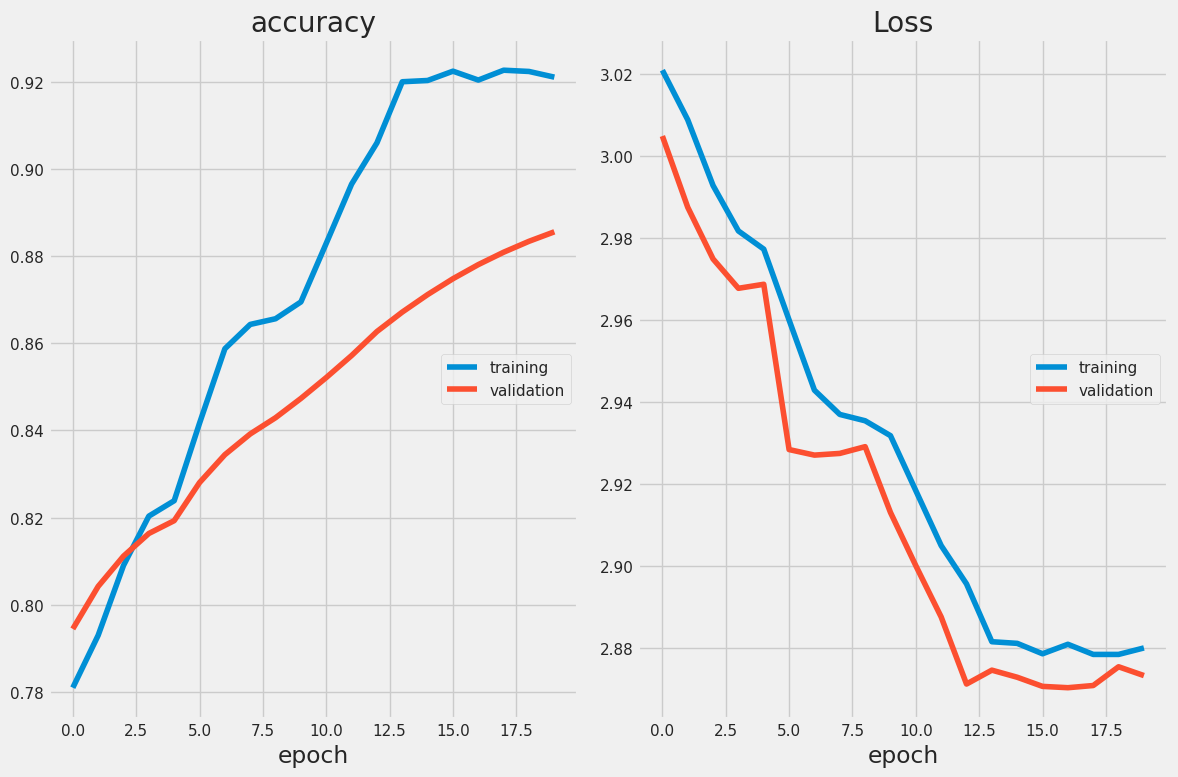

100%|██████████| 20/20 [08:11<00:00, 24.60s/it]


In [102]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from torch.utils.tensorboard import SummaryWriter
from livelossplot import PlotLosses
from livelossplot.outputs import BokehPlot, MatplotlibPlot
from datetime import datetime
import tqdm
import csv, os

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

epoch_number = 0

log_dir= f"runs/classify/logs_{timestamp}"

model_dir= f"runs/classify/model"

weights_path = os.path.join(model_dir,'weights')




os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(weights_path, exist_ok=True)

csv_path = os.path.join(log_dir, "metrics.csv")

with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "val_loss"])

best_vloss = 1_000_000.

EPOCHS=20

liveloss = PlotLosses(outputs=[MatplotlibPlot()])

valid_preds=[]
valid_truth=[]


early_stopping = EarlyStopping(patience=10, verbose=False,save_path=weights_path)

for epoch in tqdm.tqdm(range(EPOCHS)):

    logs={}
    
    # print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    
    avg_loss,train_acc = train_one_epoch(epoch_number, writer)

    logs['loss'] = avg_loss
    logs['accuracy']=train_acc

    running_vloss = 0.0
   
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        
        for i, vdata in enumerate(valid_loader):
            
            vinputs, vlabels = vdata
            
            vinputs,vlables=vinputs.to(device),vlabels.to(device)
            
            voutputs = model(vinputs)
            
            vloss = loss_fn(voutputs.to(device), vlabels.to(device))
            
            running_vloss += vloss.item()

            valid_preds.extend(voutputs.argmax(dim=1, keepdim=True).view(-1).tolist())

            valid_truth.extend(vlabels.view(-1).tolist())

    avg_vloss = running_vloss / (i + 1)

    valid_acc=compute_accuracy(valid_truth,valid_preds)

    logs['val_loss'] = avg_vloss
    logs['val_accuracy']=valid_acc
    
    with open(csv_path, 'a', newline='') as f:
        
        writer = csv.writer(f)
        
        writer.writerow([epoch_number + 1, avg_loss, avg_vloss])

    
    
    # Track best performance, and save the model's state
    
    # if avg_vloss < best_vloss:
        
    #     best_vloss = avg_vloss
        
        

    #     os.makedirs(log_dir, exist_ok=True)
            
    #     torch.save(model.state_dict(), os.path.join(weights_path,'best.pt'))

    early_stopping(avg_vloss, model)
    if early_stopping.early_stop:
        print('Model training stopped because no further improvement in Validation loss decrease was obtained')
        print('Current model loss:{}'.format(avg_loss))
        print('Current model accuracy:{}'.format(valid_acc))
        break
        
    liveloss.update(logs)
    liveloss.send()

    epoch_number += 1

   

# Model Evaluation

In [44]:
model.eval()
y_pred=[]
y_true=[]
    # Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    
    for i, vdata in tqdm.tqdm(enumerate(valid_loader)):
        
        vinputs, v_labels = vdata
        
        vinputs,vlables=vinputs.to(device),vlabels.to(device)
        
        voutputs = model(vinputs)
        
        y_pred.extend(voutputs.argmax(dim=1, keepdim=True).view(-1).tolist())

        y_true.extend(v_labels.view(-1).tolist())

            

            
            

246it [00:05, 46.87it/s]


In [71]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f'model accuracy:{accuracy}')

model accuracy:0.3620249936240755


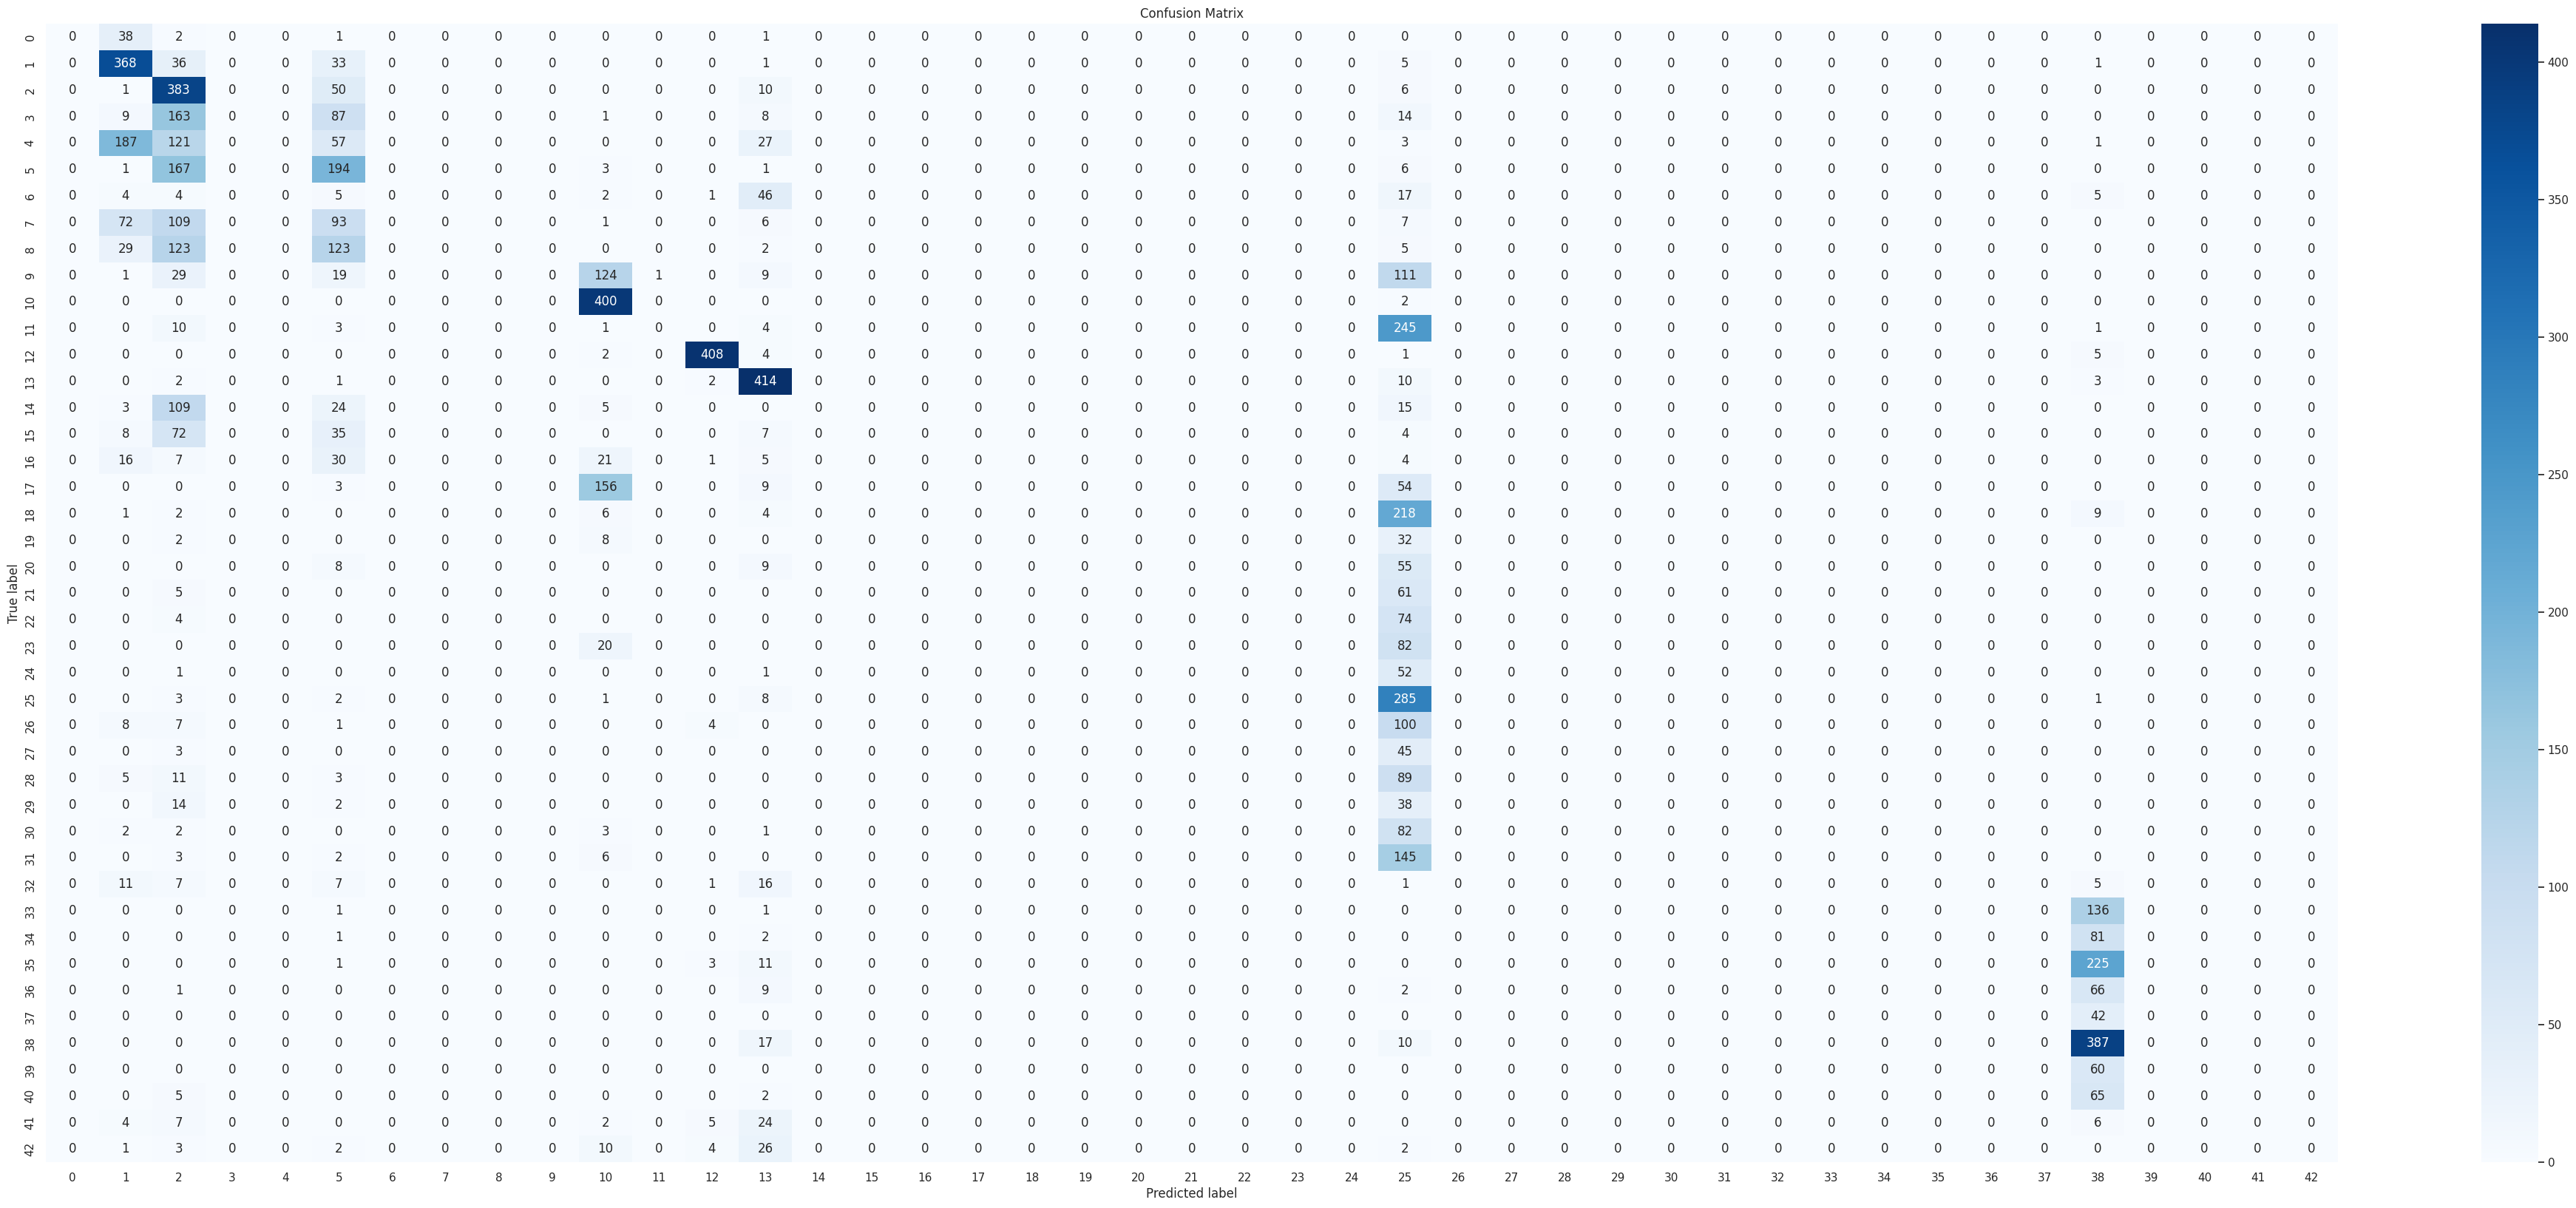

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
cm=confusion_matrix(y_true,y_pred)
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(1,figsize=(50,20))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()




In [66]:
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.48      0.83      0.61       444
           2       0.27      0.85      0.41       450
           3       0.00      0.00      0.00       282
           4       0.00      0.00      0.00       396
           5       0.25      0.52      0.33       372
           6       0.00      0.00      0.00        84
           7       0.00      0.00      0.00       288
           8       0.00      0.00      0.00       282
           9       0.00      0.00      0.00       294
          10       0.52      1.00      0.68       402
          11       0.00      0.00      0.00       264
          12       0.95      0.97      0.96       420
          13       0.60      0.96      0.74       432
          14       0.00      0.00      0.00       156
          15       0.00      0.00      0.00       126
          16       0.00      0.00      0.00        84
    

# Tensorflow Implementation

In [77]:
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
    fill_mode='nearest'
    
)

train_gen_aug = train_datagen_aug.flow_from_dataframe(
    dataframe = train_data,
    directory=train_imgs,
    x_col = "Path",
    y_col = "ClassId_str",
    target_size = IMG_SIZE,
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 31367 validated image filenames belonging to 43 classes.


In [78]:
class_indices = train_gen_aug.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

In [79]:
valid_datagen_aug = ImageDataGenerator(rescale=1./255)
test_datagen_aug = ImageDataGenerator(rescale=1./255)

valid_gen_aug = valid_datagen_aug.flow_from_dataframe(
    dataframe = valid_data,
    directory = train_imgs,
    x_col = "Path",
    y_col = "ClassId_str",
    target_size = IMG_SIZE,
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    shuffle = False
)



test_df["ClassId_str"] = test_df["ClassId"].astype(str)
test_df["ClassId"] = test_df["ClassId"].astype(int)
test_df["Path"] = test_df["Path"].str.replace("Test/", "")

test_gen_aug = test_datagen_aug.flow_from_dataframe(
    dataframe = test_df,
    directory=test_imgs,
    x_col = "Path",
    y_col = "ClassId_str",
    target_size = IMG_SIZE,
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 7842 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


In [80]:
class_weight = compute_class_weight('balanced', classes=np.unique(train_df['ClassId']),
                                  y=train_df['ClassId'])
class_weights_dict = dict(enumerate(class_weight))
class_weights_dict

{0: 4.342081949058693,
 1: 0.41073748166771423,
 2: 0.4052609819121447,
 3: 0.6466930562427841,
 4: 0.46052384308198263,
 5: 0.49023505876469115,
 6: 2.1710409745293466,
 7: 0.6332202842377261,
 8: 0.6466930562427841,
 9: 0.620297421294099,
 10: 0.45365035288672917,
 11: 0.6907857646229739,
 12: 0.4342081949058693,
 13: 0.4221468561584841,
 14: 1.1690220632081096,
 15: 1.447360649686231,
 16: 2.1710409745293466,
 17: 0.8214749633354285,
 18: 0.7598643410852713,
 19: 4.342081949058693,
 20: 2.5328811369509046,
 21: 2.7631430584918957,
 22: 2.3380441264162193,
 23: 1.7879160966712266,
 24: 3.3771748492678726,
 25: 0.6078914728682171,
 26: 1.5197286821705427,
 27: 3.7993217054263564,
 28: 1.6885874246339363,
 29: 3.3771748492678726,
 30: 2.0263049095607237,
 31: 1.1690220632081096,
 32: 3.7993217054263564,
 33: 1.3234212036318223,
 34: 2.1710409745293466,
 35: 0.7598643410852713,
 36: 2.3380441264162193,
 37: 4.342081949058693,
 38: 0.44050106729580946,
 39: 3.0394573643410854,
 40: 2.532

In [81]:
train_gen_aug.class_indices == valid_gen_aug.class_indices 

True

In [82]:
model_aug = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"),
    Conv2D(32, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding="same"),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding="same"),
    Conv2D(256, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

I0000 00:00:1760510136.658912      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13820 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760510136.659575      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [83]:
model_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,443 (1.81 MB)

 Trainable params: 473,739 (1.81 MB)

 Non-trainable params: 704 (2.75 KB)

In [84]:
model_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', 
             metrics = ['accuracy'])

In [85]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 8)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 2, factor = 0.2, 
                                              min_lr = 1e-5)

In [86]:
history_aug=model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, batch_size=BATCH_SIZE, epochs=EPOCHS,
                  callbacks=[early_stopping, reduce_lr], class_weight=class_weights_dict)

Epoch 1/2


I0000 00:00:1760510143.713135     358 service.cc:148] XLA service 0x79eae806ff70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760510143.713904     358 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760510143.713936     358 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760510144.282856     358 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/981 ━━━━━━━━━━━━━━━━━━━━ 1:24 87ms/step - accuracy: 0.0191 - loss: 6.2291  

I0000 00:00:1760510149.356960     358 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


981/981 ━━━━━━━━━━━━━━━━━━━━ 199s 192ms/step - accuracy: 0.1271 - loss: 4.7018 - val_accuracy: 0.4806 - val_loss: 1.7684 - learning_rate: 0.0010
Epoch 2/2
981/981 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.5372 - loss: 1.5790 - val_accuracy: 0.8597 - val_loss: 0.4345 - learning_rate: 0.0010


In [87]:
test_loss, test_accuracy = model_aug.evaluate(test_gen_aug)
print(f"Test accuracy : {test_accuracy*100:.2f}%")
print(f"Test loss : {test_loss:.3f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 69s 175ms/step - accuracy: 0.8317 - loss: 0.5493
Test accuracy : 83.03%
Test loss : 0.544


In [88]:
valid_loss, valid_accuracy = model_aug.evaluate(valid_gen_aug)
print(f"Validation accuracy : {valid_accuracy*100:.2f}%")
print(f"Validation loss : {valid_loss:.3f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8706 - loss: 0.4215
Validation accuracy : 85.97%
Validation loss : 0.435


In [89]:
idx_to_class = {v: k for k, v in train_gen_aug.class_indices.items()}
true_labels = test_gen_aug.classes  
pred_probs = model_aug.predict(test_gen_aug)        
pred_labels = np.argmax(pred_probs, axis=1) 
target_names = list(test_gen_aug.class_indices.keys())
print(classification_report(true_labels, pred_labels, target_names=target_names))

395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step
              precision    recall  f1-score   support

           0       0.57      0.65      0.60        60
           1       0.90      0.86      0.88       720
          10       0.98      0.97      0.97       660
          11       0.76      0.81      0.79       420
          12       0.90      0.91      0.90       690
          13       0.98      0.98      0.98       720
          14       0.97      1.00      0.99       270
          15       1.00      0.98      0.99       210
          16       1.00      0.83      0.91       150
          17       1.00      0.82      0.90       360
          18       0.88      0.57      0.69       390
          19       0.00      0.00      0.00        60
           2       0.77      0.84      0.80       750
          20       0.00      0.00      0.00        90
          21       0.00      0.00      0.00        90
          22       0.77      0.74      0.75       120
          23       0.34      0.89     

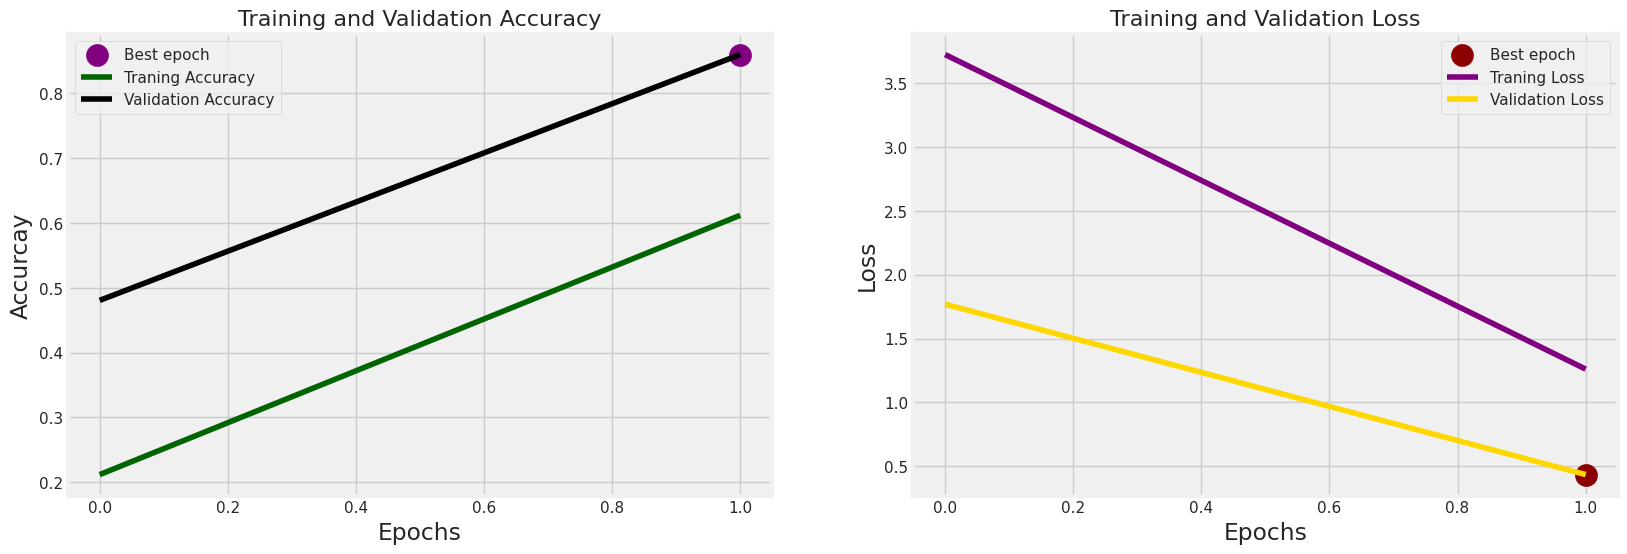

In [90]:
#train history
train_acc = history_aug.history['accuracy']
train_loss = history_aug.history['loss']

#validatioin history
val_acc = history_aug.history['val_accuracy']
val_loss = history_aug.history['val_loss']

min_loss = np.argmin(val_loss) # get min val loss epoch #
val_lowest = val_loss[min_loss]

max_acc = np.argmax(val_acc) #get max val acc epoch #
val_max = val_acc[max_acc]

epochs_ = [i for i in range(len(train_acc))]

#Plot Style
plt.figure(figsize = (20,6))
plt.style.use('fivethirtyeight')

#Plot Accuracy
plt.subplot(1, 2, 1)
plt.scatter(max_acc, val_max, s = 250, c = "purple", label = "Best epoch")
plt.plot(epochs_, train_acc, 'darkgreen', label = "Traning Accuracy")
plt.plot(epochs_, val_acc, 'black', label = "Validation Accuracy")

plt.title("Training and Validation Accuracy", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Accurcay")
plt.legend()

#Plot Loss
plt.subplot(1, 2, 2)
plt.scatter(min_loss, val_lowest, s = 250, c = "darkred", label = "Best epoch")
plt.plot(epochs_, train_loss, 'purple', label = "Traning Loss")
plt.plot(epochs_, val_loss, 'gold', label = "Validation Loss")

plt.title("Training and Validation Loss", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

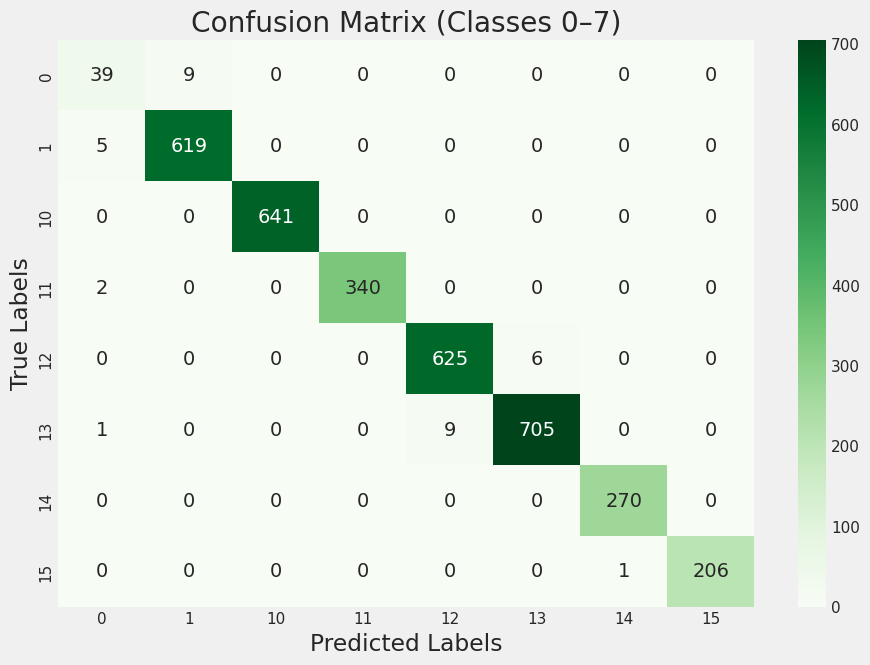

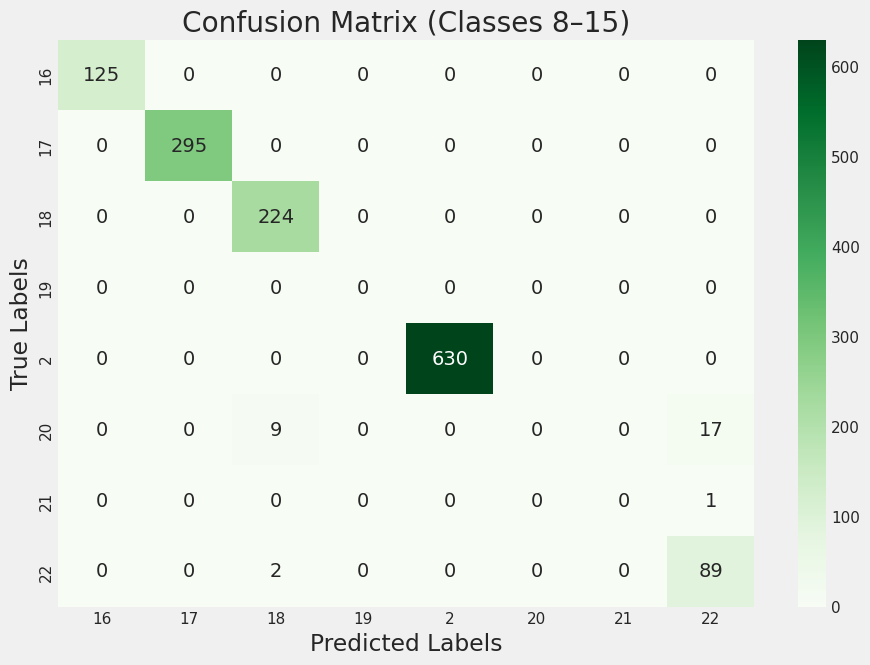

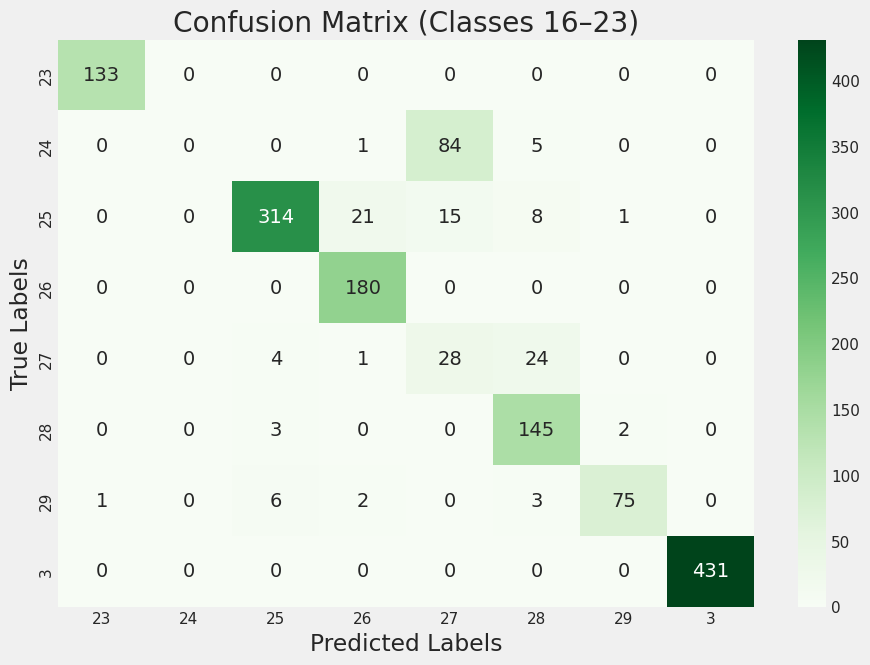

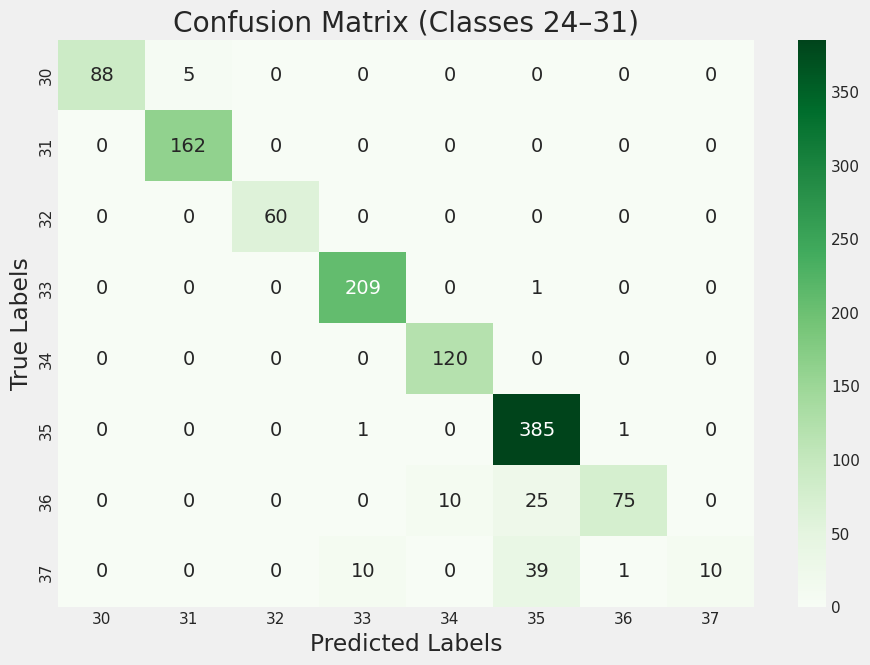

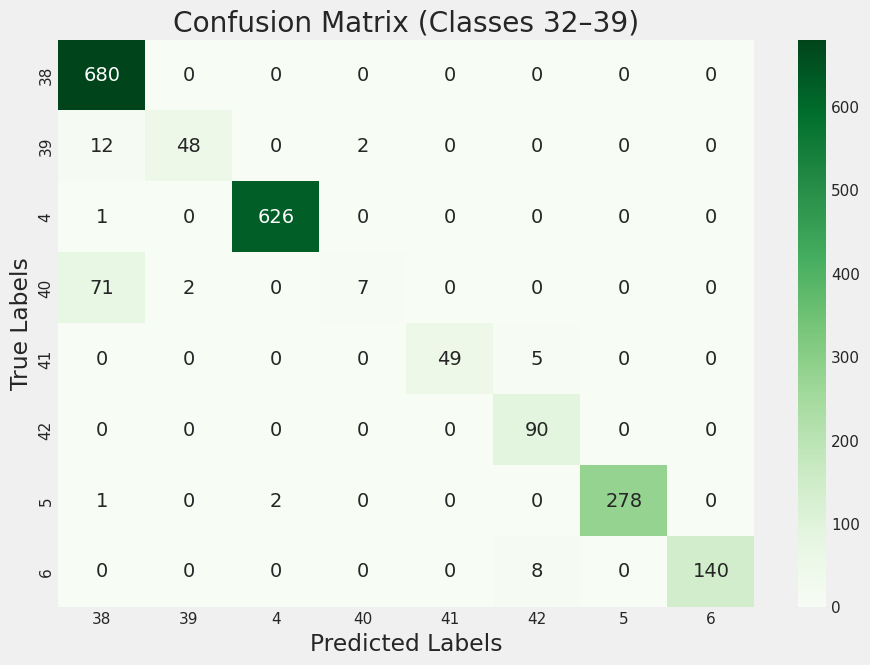

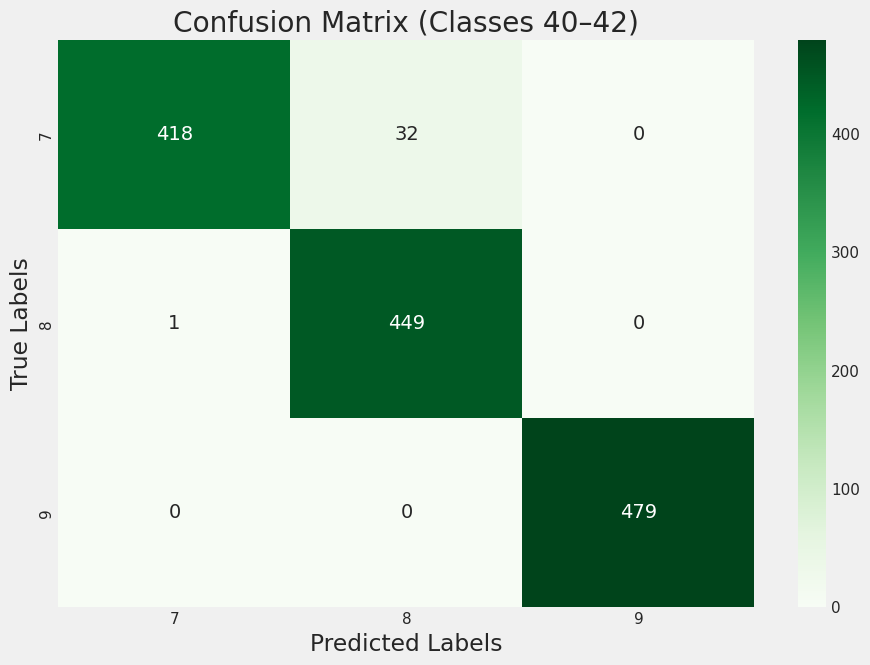

In [91]:
cm = confusion_matrix(true_labels, pred_labels)
class_names = list(test_gen_aug.class_indices.keys())
chunk_size = 8
for start in range(0, len(class_names), chunk_size):
    end = min(start + chunk_size, len(class_names))
    cm_sliced = cm[start:end, start:end]
    labels_sliced = class_names[start:end]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_sliced, annot=True, cmap='Greens', fmt="d",
                xticklabels=labels_sliced, yticklabels=labels_sliced)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix (Classes {start}–{end-1})")
    plt.show()

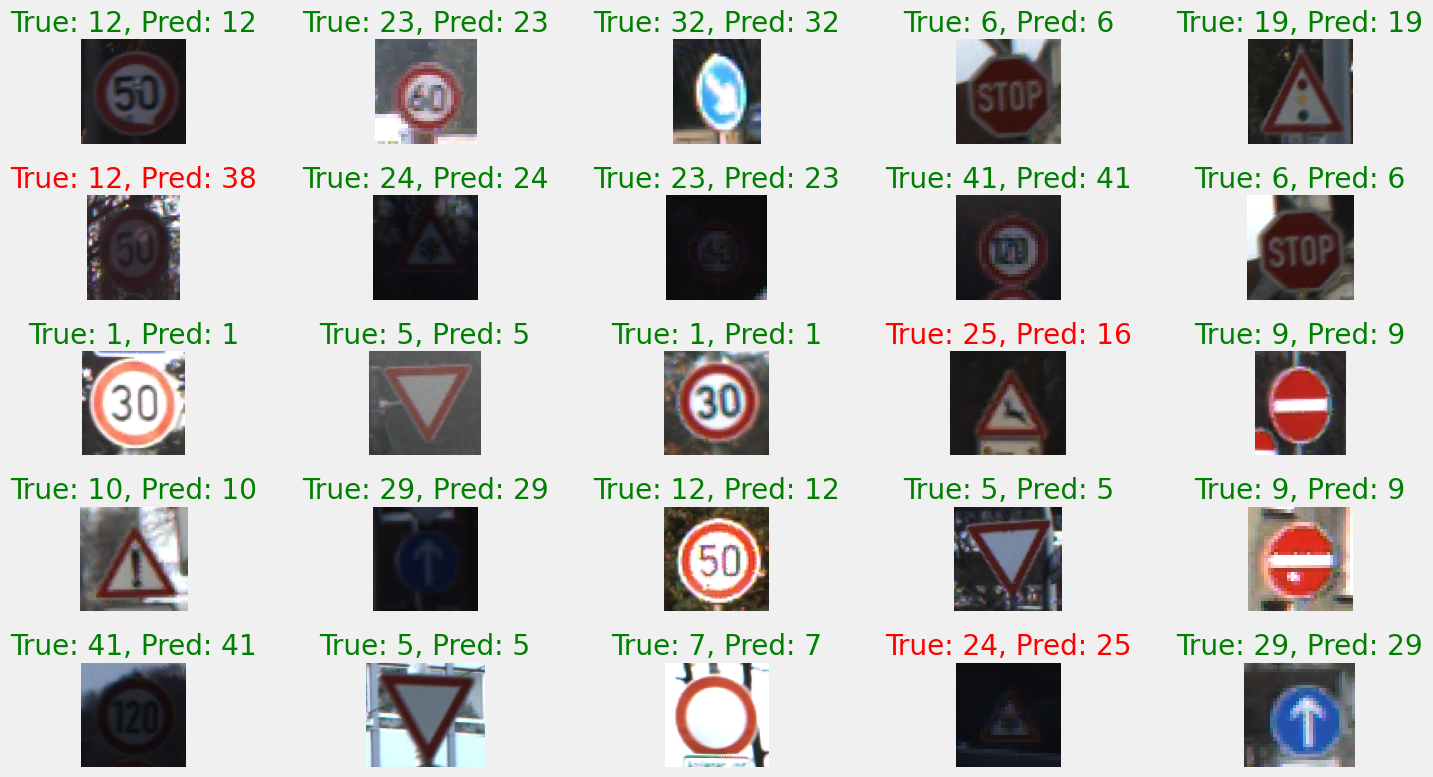

In [92]:
file_paths = test_gen_aug.filepaths
num_imgs = 25
indices = random.sample(range(len(file_paths)), num_imgs)

plt.figure(figsize=(16, 8))

for i, idx in enumerate(indices):
    img_path = file_paths[idx]
    img = plt.imread(img_path)

    true_label = true_labels[idx]
    pred_label = pred_labels[idx]
    color = "green" if true_label == pred_label else "red"
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}", color=color)
    plt.axis("off")


plt.tight_layout()
plt.show()